In [1]:
import pandas as pd
import numpy as np

data = pd.read_csv('Code Data/train.csv', index_col='Id')

numeric = data.select_dtypes(include=[np.number])
numeric.columns

corr_numer = numeric.corr()
correlation = pd.DataFrame(corr_numer['SalePrice'].sort_values(ascending=False))
correlation = correlation[correlation['SalePrice'] >0.5]
numerical_cols = correlation.index
numerical_cols = numerical_cols.tolist()

categorical_cols = data.select_dtypes(include = object).columns
categorical_cols = categorical_cols.tolist()

cols = numerical_cols + categorical_cols

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,GridSearchCV
import matplotlib.pyplot as plt

# Read the data
X = pd.read_csv('Code Data/train.csv', index_col='Id')
test = pd.read_csv('Code Data/test.csv', index_col='Id')

#X['SalePrice'] = np.log1p(X['SalePrice'])

# Remove rows with missing target, separate target from predictors
X.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = X.SalePrice
X.drop(['SalePrice'], axis=1, inplace=True)

object_cols = list(X.select_dtypes(include=['object']).columns)

# convert object columns to categorical columns
X[object_cols] = X[object_cols].astype('category')

# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, test_size=0.2, random_state=1)

# "Cardinality" means the number of unique values in a column
# Select categorical columns with relatively low cardinality (convenient but arbitrary)
categorical_cols = [cname for cname in X_train.columns if
                    X_train[cname].nunique() < 10 and 
                    X_train[cname].dtype == "category"]

# Select numerical columns
numerical_cols = [cname for cname in X_train.columns if 
                X_train[cname].dtype in ['int64', 'float64']]



In [3]:
y_train

Id
922     145900
521     106250
402     164990
281     228500
1402    193000
         ...  
716     165000
906     128000
1097    127000
236      89500
1062     81000
Name: SalePrice, Length: 1168, dtype: int64

In [4]:
# Keep selected columns only
my_cols = categorical_cols + numerical_cols
X_train = X_train[my_cols].copy()
X_test = X_test[my_cols].copy()

In [5]:
ordinal_cols =["HeatingQC", "BsmtQual", "ExterQual", "GarageCond", "GarageQual", "KitchenQual", "BsmtFinType1", "BsmtExposure"]
nominal_cols = ["CentralAir", "Foundation", "MasVnrType", "HouseStyle", "LotShape", "MSZoning", "SaleCondition", "SaleType", "GarageFinish", "GarageType"]

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.metrics import mean_absolute_error,mean_squared_error, r2_score, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor

In [7]:
# Define the pipeline steps for numerical and categorical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')) # fill missing values with mean
])

ordinal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # fill missing values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore')) # one hot encoding for categorical columns
])

#nominal_encoder = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('label', LabelEncoder(handle_unknown='ignore'))
#])

# Combine numerical and categorical transformers using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('ord', ordinal_transformer, ordinal_cols)
])

Gradient Boost Regressor
MSE: 600851222.5996006
MAE: 15018.059883569565
MAPE 9.429443018348222 %
R2 : 91.57521041771969 %


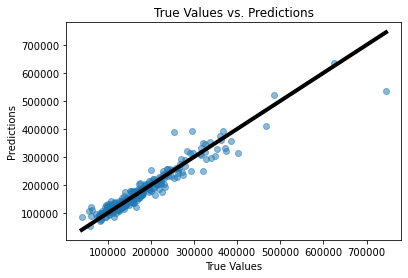


XGB Regressor
MSE: 621663334.980493
MAE: 15021.856873394692
MAPE 9.364457368076518 %
R2 : 91.28339497160445 %


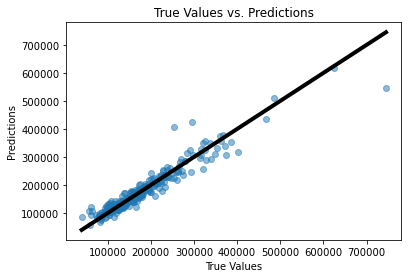

In [8]:
# Define model
xgb_model = XGBRegressor(learning_rate=0.1, n_estimators=200, max_depth=3, random_state=1)
gbr_model = GradientBoostingRegressor(loss='squared_error', learning_rate=0.05, n_estimators=200, max_depth=3, random_state=1)
svr_model = SVR(kernel='poly', C=0.1, gamma=0.1)
lr_model = LinearRegression()

# Gradient Boost Regression model
gbr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', gbr_model)
                     ])

gbr.fit(X_train, y_train)
preds = gbr.predict(X_test)


print('Gradient Boost Regressor')
print('MSE:', mean_squared_error(y_test, preds))
print('MAE:', mean_absolute_error(y_test, preds))
print('MAPE', mean_absolute_percentage_error(y_test, preds)*100, '%')
print('R2 :', r2_score(y_test,preds)*100, '%')


# Plot the scatter plot
plt.scatter(y_test, preds, alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Add the line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=4)
plt.title('True Values vs. Predictions')

plt.show()

# XGB Regressor model
xgb = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', xgb_model)
                     ])

xgb.fit(X_train, y_train)
preds = xgb.predict(X_test)

print('\nXGB Regressor')
print('MSE:', mean_squared_error(y_test, preds))
print('MAE:', mean_absolute_error(y_test, preds))
print('MAPE', mean_absolute_percentage_error(y_test, preds)*100, '%')
print('R2 :', r2_score(y_test,preds)*100, '%')

# Plot the scatter plot
plt.scatter(y_test, preds, alpha = 0.5)
plt.xlabel('True Values')
plt.ylabel('Predictions')

# Add the line
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k-', lw=4)
plt.title('True Values vs. Predictions')

plt.show()



In [9]:
import pickle

pickle.dump(gbr, open('model.pkl', 'wb'))

In [10]:
pickled_model = pickle.load(open('model.pkl', 'rb'))
pickled_model.predict(test)

array([127431.24227398, 157751.42641037, 177819.38499741, ...,
       169373.03350165, 126616.76857641, 240278.16928915])

In [11]:
test['SalePrice'] = gbr.predict(test)

In [12]:
test

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal,127431.242274
1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal,157751.426410
1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal,177819.384997
1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2010,WD,Normal,183565.702950
1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,0,NaN,NaN,NaN,0,1,2010,WD,Normal,191311.002910
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,6,2006,WD,Normal,83730.942783
2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml,88554.236573
2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml,169373.033502
